In [16]:
#importing relavent libraries
import os

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from skimage.color import rgb2gray
from skimage.transform import resize

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers, optimizers, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score, AUC

import itertools
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#dataset name
DATASET = 'horses_or_humans'

#resize and grayscale
RESIZE = (64, 64, 3)
GRAY_SCALE = True

#loading dataset from tensorflow
df = tfds.load(DATASET, split='all', shuffle_files=True)

#initialize list for storing
images, labels = [], []
for entry in df.take(len(df)) :
    #extract image and labels
    image, label = entry['image'], entry['label']
    
    #convert to numpy array
    image, label = image.numpy(), label.numpy()
    
    #resizing images
    image = resize(image, RESIZE, anti_aliasing=True)
    
    #converting to grayscale
    if GRAY_SCALE :
        image = rgb2gray(image)
    
    #apend to the array
    images.append( image )
    labels.append( label )

In [3]:
#list of images to numpy array
X = np.array(images)

#binary output, 0 or 1
y = np.array(labels)

#show total images
print(len(X))

1283


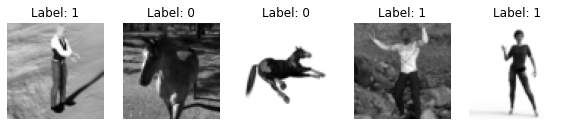

In [4]:
import random

#number of random images to display
num_images_to_show = 5

#get the total number of images in the dataset
total_images = X.shape[0]

#generate random samples of images
random_indices = random.sample(range(total_images), num_images_to_show)

#show the random images
plt.figure(figsize=(10, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(X[idx], cmap='gray' if GRAY_SCALE else None)
    plt.title('Label: {}'.format(y[idx]))
    plt.axis('off')
plt.show()

In [5]:
#10% of the dataset is set aside for testing purposes
test_size = 0.1

#Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, stratify=y, random_state=SEED, shuffle=True
)

#Normalize pixel values to the range [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

#10% of training data for validation
val_size = 0.1  

#Split the training set into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_size, stratify=y_train, shuffle=True, random_state=SEED
)

#Convert label data types to float for compatibility with certain loss functions
y_train, y_val, y_test = y_train.astype(float), y_val.astype(float), y_test.astype(float)

In [6]:
#count the number of samples for each label in the training set
train_label_counts = np.bincount(y_train.astype(int))

#count the number of samples for each label in the validation set
val_label_counts = np.bincount(y_val.astype(int))

#count the number of samples for each label in the test set
test_label_counts = np.bincount(y_test.astype(int))

#print the number of samples per label
print("Training set label counts:", train_label_counts)
print("Validation set label counts:", val_label_counts)
print("Test set label counts:", test_label_counts)

Training set label counts: [508 530]
Validation set label counts: [57 59]
Test set label counts: [63 66]


In [7]:
#baase cnn model
model = models.Sequential([
    #First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3 if not GRAY_SCALE else 1)),
    layers.MaxPooling2D((2, 2)),
    
    #Second Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    #Third Convolutional Layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    #Flatten the output for the fully connected layers
    layers.Flatten(),
    
    #Fully connected layer
    layers.Dense(64, activation='relu'),
    
    #Output layer with a single neuron for binary classification (0 or 1)
    layers.Dense(1, activation='sigmoid')
])

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC()])

In [9]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, 
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_val, y_val),  #Validate on validation set
                    callbacks = [early_stopping],
                    verbose=1) 

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5048 - auc: 0.4822 - loss: 0.6936 - val_accuracy: 0.4914 - val_auc: 0.5000 - val_loss: 0.6931
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4664 - auc: 0.5000 - loss: 0.6932 - val_accuracy: 0.5086 - val_auc: 0.5000 - val_loss: 0.6931
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5102 - auc: 0.4801 - loss: 0.6931 - val_accuracy: 0.5086 - val_auc: 0.5000 - val_loss: 0.6930
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5102 - auc: 0.5000 - loss: 0.6931 - val_accuracy: 0.5086 - val_auc: 0.5000 - val_loss: 0.6930
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5102 - auc: 0.5000 - loss: 0.6931 - val_accuracy: 0.5086 - val_auc: 0.5000 - val_loss: 0.6930
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5102 - auc: 0.5000 - loss: 0.6930 - val_accuracy: 0.5086 - val_auc: 0.5000 - val_loss: 0.6929
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9599 - auc: 0.9892 - loss: 0.1358 - val_accuracy: 0.9397 - val_auc: 0.9811 - val_loss: 0.1749
Epoch 44/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9593 - auc: 0.9902 - loss: 0.1286 - val_accuracy: 0.9483 - val_auc: 0.9826 - val_loss: 0.1655
Epoch 45/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9614 - auc: 0.9908 - loss: 0.1239 - val_accuracy: 0.9397 - val_auc: 0.9838 - val_loss: 0.1675
Epoch 46/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9619 - auc: 0.9917 - loss: 0.1172 - val_accuracy: 0.9483 - val_auc: 0.9845 - val_loss: 0.1573
Epoch 47/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9655 - auc: 0.9930 - loss: 0.1106 - val_accuracy: 0.9483 - val_auc: 0.9841 - val_loss: 0.1576
Epoch 48/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9644 - auc: 0.9939 - loss: 0.1046 - val_accuracy: 0.9569 - val_auc: 0.9862 - val_loss: 0.1462
Epoch 49/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step 

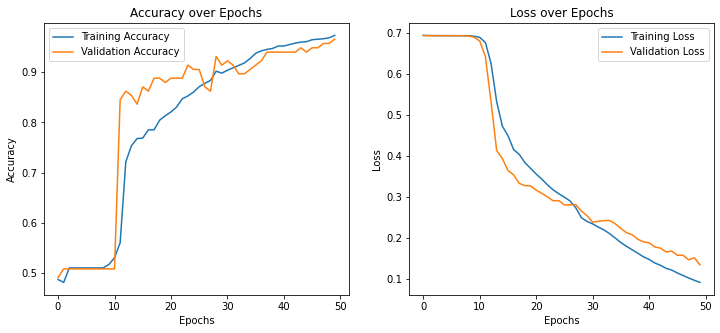

In [10]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

#Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test AUC: {test_auc:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9576 - auc: 0.9891 - loss: 0.1278 
Test Accuracy: 95.35%
Test AUC: 0.99


In [12]:
#Convert probabilities to binary predictions (0 or 1)
y_pred = (model.predict(X_test) > 0.5).astype(int)
f1 = f1_score(y_test, y_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [13]:
#F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.95


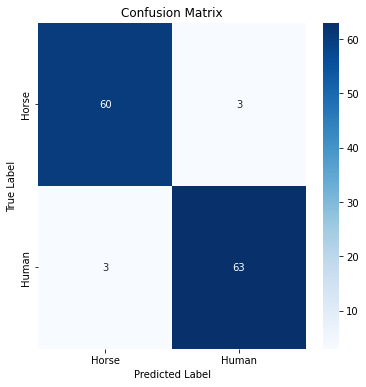

In [18]:
cm = confusion_matrix(y_test, y_pred)
#Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Horse', 'Human'], yticklabels=['Horse', 'Human'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()